## 這裡依照Final最佳模型方案GMM步驟擴展到高維度資料來處理private_dataset


In [2]:
# Step 0: 檔案上傳
from google.colab import files
uploaded = files.upload()
# Step 1: 加套件與資料標準化
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Step 2: 讀檔與前處理
# 對欄位 1 至 6 取對數（加 1 避免 log(0)）

df = pd.read_csv("private_data.csv")  # 確認你的檔名一致
id_list = df["id"].values
log_data = np.log1p(df.drop(columns=['id']))
scaled_data = StandardScaler().fit_transform(log_data)
num_columns = df.shape[1]-1

print("df 的欄位數量:", num_columns)
best_k = (num_columns*4)-1
best_k
print("分幾群:", best_k)
# --- 最優方法：GMM with full covariance ---Score: 0.8548
gmm_full = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm_full_labels = gmm_full.fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": gmm_full_labels}).to_csv("private_submission_gmm_full.csv", index=False)
data_length = df.shape[0]
print(f"資料總筆數為：{data_length}")

Saving private_data.csv to private_data (1).csv
df 的欄位數量: 6
分幾群: 23
資料總筆數為：200000


## 以下是分析過程的詳細程式碼和結果

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Block/bigdata/public_data.csv"

df = pd.read_csv(file_path)

# 顯示前幾列與欄位資訊，確認欄位名
df.head(), df.columns

(   id    1    2    3    4
 0   1    0   28  262  577
 1   2   54  502  209   22
 2   3  694  379   46    0
 3   4  546  217   16    0
 4   5   36  404  685   80,
 Index(['id', '1', '2', '3', '4'], dtype='object'))

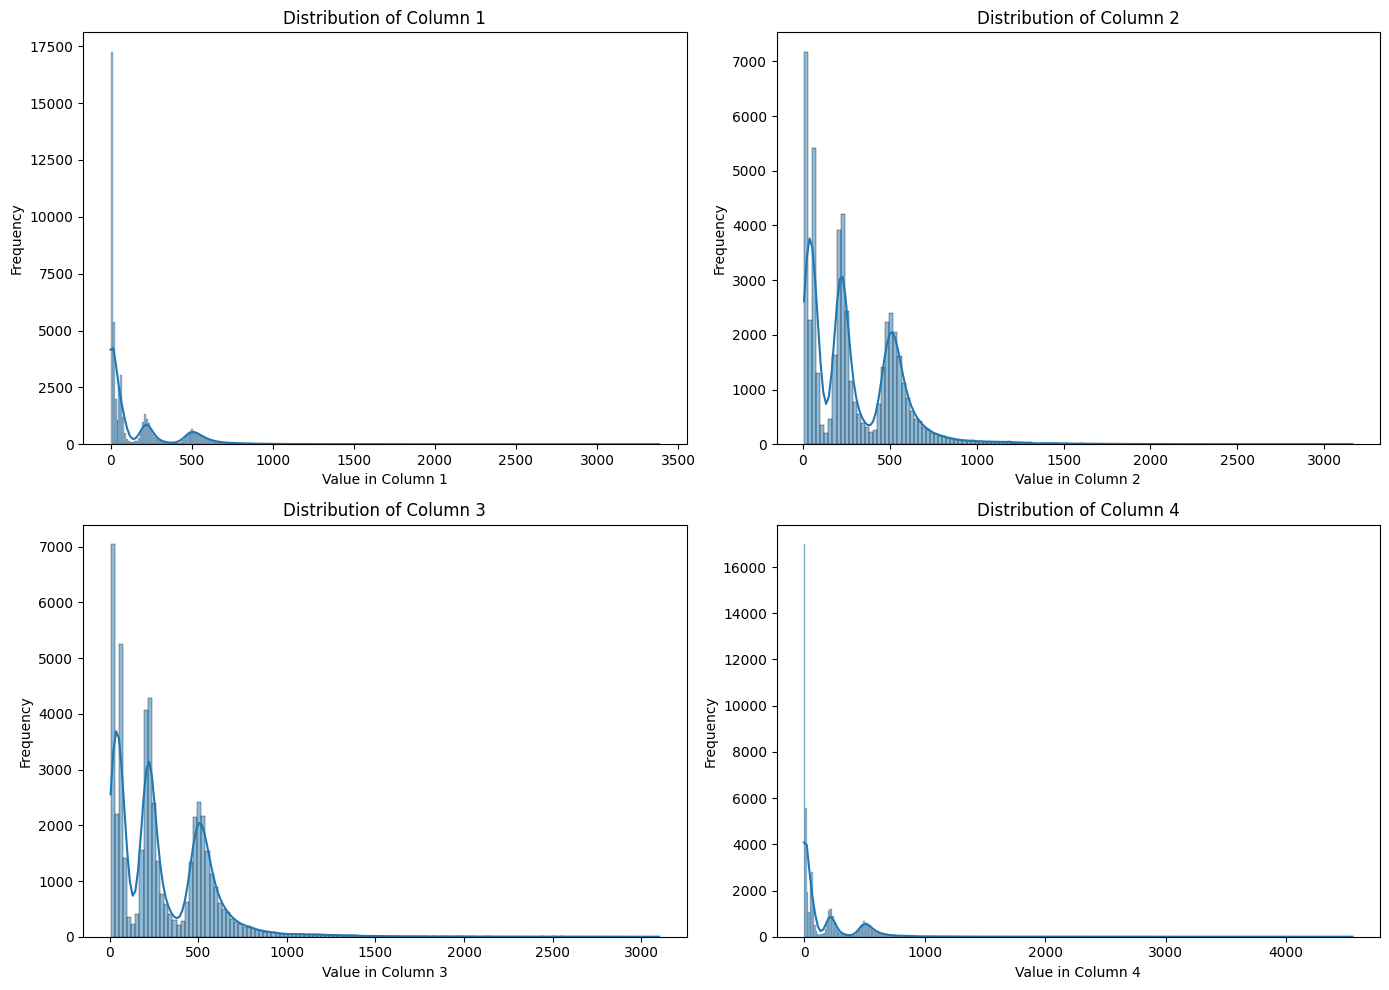

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 只選擇欄位 1 至 4
data_subset = df[['1', '2', '3', '4']]

# 畫出每個欄位的分佈圖（直方圖+密度圖）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(data_subset.columns):
    sns.histplot(data_subset[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of Column {col}")
    axes[i].set_xlabel(f"Value in Column {col}")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


上圖顯示了欄位 1 到 4 的資料分布情形：

欄位 1：資料集中在 0 附近，有大量為 0 的值，呈現明顯偏態（skewed distribution）。

欄位 2：呈現多峰分布，有多個常見數值區間，資料分布範圍較廣。

欄位 3：也偏態分布，有一部分資料值為 0 或接近 0，但右側有較長的尾巴。

欄位 4：分布較平均但略帶右偏，有集中值但也存在高值區。

以下進一步分析這些欄位的統計量（如平均值、標準差、偏態、峰態 等）

In [ ]:
from scipy.stats import skew, kurtosis

# 計算統計量：平均值、標準差、偏態、峰態
stats_df = pd.DataFrame({
    'N': data_subset.count(),
    'Mean': data_subset.mean(),
    'Std Dev': data_subset.std(),
    'Skewness': data_subset.apply(skew),
    'Kurtosis': data_subset.apply(kurtosis)
})
# 加入最大值、最小值與中位數
stats_df['Min'] = data_subset.min()
stats_df['Median'] = data_subset.median()
stats_df['Max'] = data_subset.max()

# 重新排列欄位順序
stats_df = stats_df[['N', 'Mean','Median', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis']]

stats_df

,N,Mean,Median,Std Dev,Min,Max,Skewness,Kurtosis
1,49771,154.368327,40.0,237.722236,0,3383,2.500545,10.903366
2,49771,297.243998,227.0,268.701666,6,3163,1.783832,7.313400
3,49771,297.949730,227.0,267.336784,6,3101,1.763431,7.158300
4,49771,157.830042,42.0,243.938851,0,4552,2.712483,14.397176


四個欄位皆包含大量為 0 的值（中位數偏低）。

最大值遠大於平均值與中位數，顯示存在極端高值。

偏態與峰態進一步證實這些欄位分布極度偏態且具厚尾特性。

以下是兩兩的correlaction plot, Public Data Scatter Plot


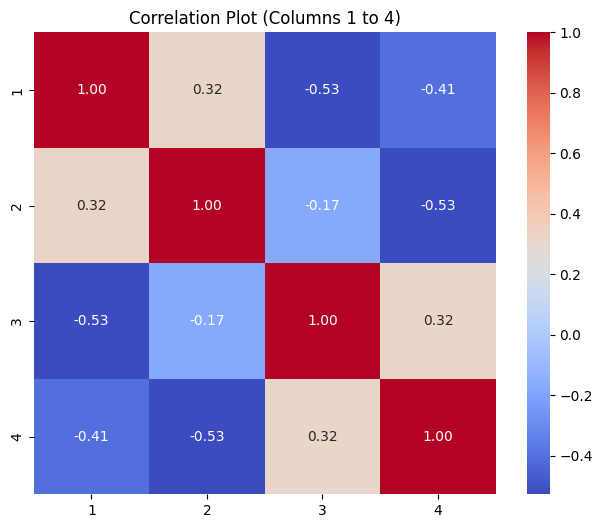

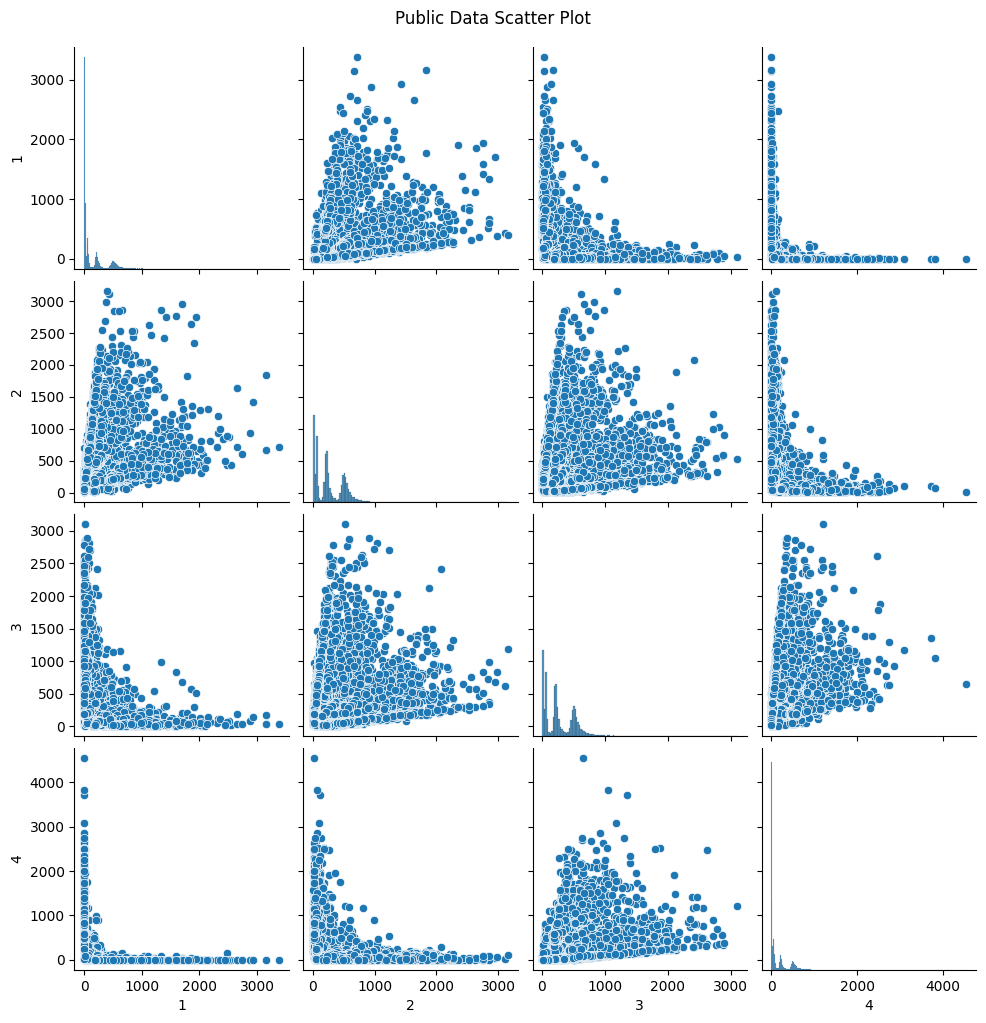

In [ ]:
# 計算欄位 1 至 4 的相關係數矩陣
correlation_matrix = data_subset.corr()

# 繪製 heatmap 相關係數圖
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Plot (Columns 1 to 4)")
plt.show()

import seaborn as sns

# 只選擇欄位 1 至 4 的資料
data_subset = df[['1', '2', '3', '4']]

# 使用 seaborn 的 pairplot 繪製兩兩散佈圖，並設定標題
g = sns.pairplot(data_subset)
g.fig.suptitle("Public Data Scatter Plot", y=1.02)  # y=1.02 調整標題位置，避免與圖表重疊


# 顯示圖表
plt.show()

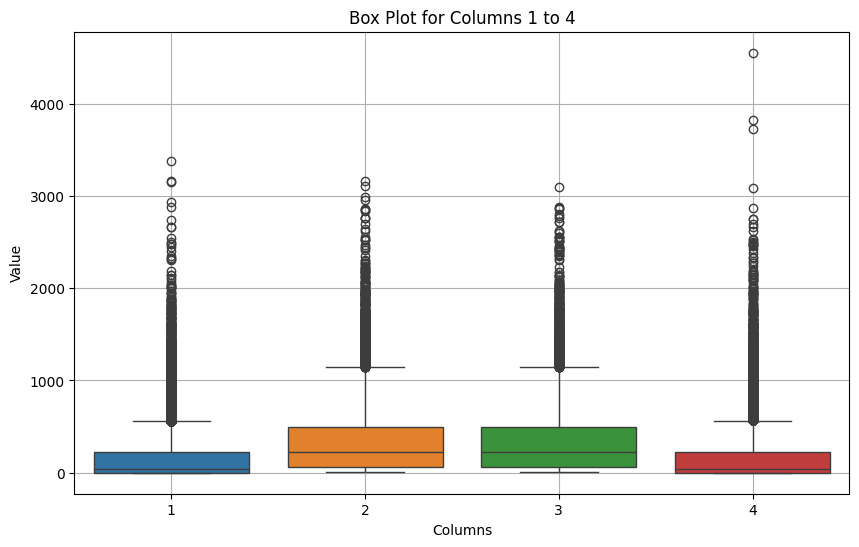

In [ ]:
"BoxＰlot"
import matplotlib.pyplot as plt
import seaborn as sns

# 繪製欄位 1~4 的 boxplot 在同一張圖
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_subset)
plt.title("Box Plot for Columns 1 to 4")
plt.xlabel("Columns")
plt.ylabel("Value")
plt.grid(True)
plt.show()


## log-scale 轉換版本

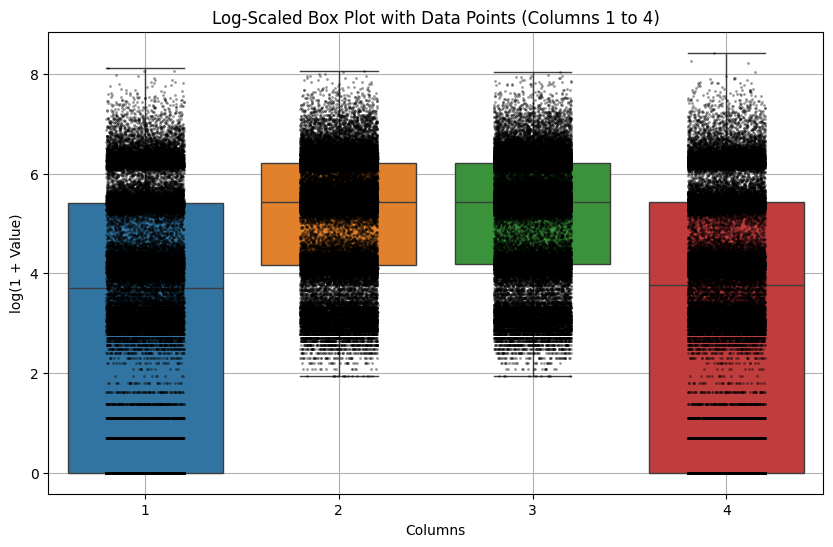

In [ ]:
# 畫出 log-scale boxplot 並加上原始數據點（抖動 jitter 效果）
import numpy as np

# 對欄位 1 至 4 取對數（加 1 避免 log(0)）
log_data = np.log1p(data_subset)

plt.figure(figsize=(10, 6))
sns.boxplot(data=log_data)
sns.stripplot(data=log_data, color='black', alpha=0.4, jitter=0.2, size=2)

plt.title("Log-Scaled Box Plot with Data Points (Columns 1 to 4)")
plt.xlabel("Columns")
plt.ylabel("log(1 + Value)")
plt.grid(True)
plt.show()


顏色區塊（藍、橘、綠、紅）：分別對應於欄位 1 至欄位 4。是每個變數的 box plot顯示其布。

盒子（Box）：表示中間 50% 的資料（第 25 百分位至第 75 百分位）。中央橫線是中位數。
鬚線（Whiskers）：延伸至 1.5 倍 IQR 內的最大與最小值（不包含極端離群值）。

黑色點（散佈點 scatter）：為所有實際資料點，經 log(1+x) 轉換後畫出。

顯示整體分布密度與集中區域,越密集的地方表示該區域資料量多。

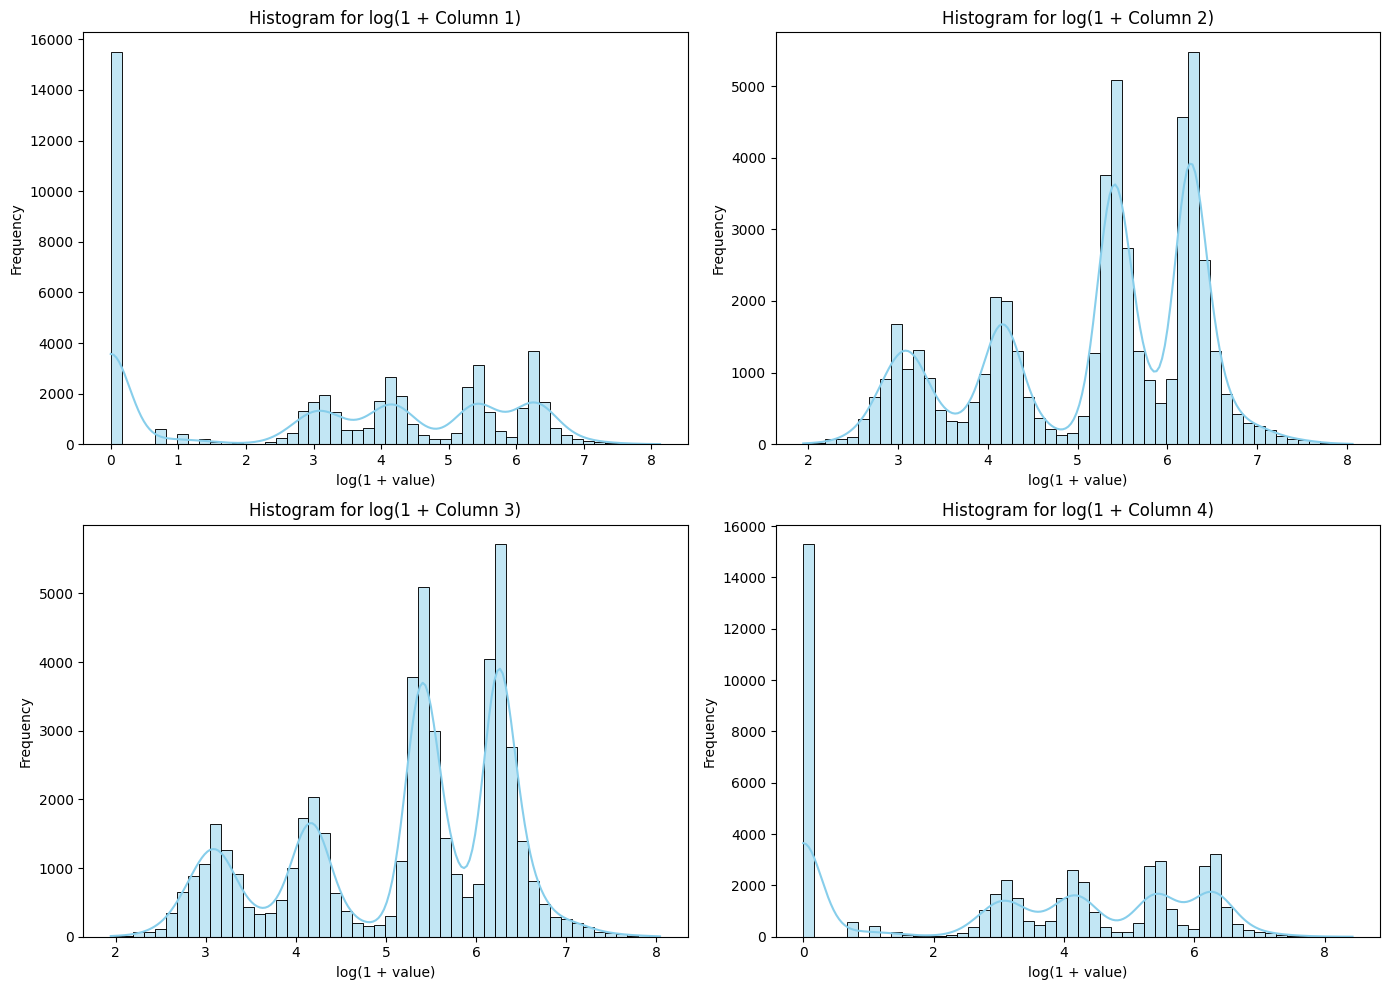

In [ ]:
# 繪製 log_data 的每個欄位的直方圖 + 密度圖
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(log_data.columns):
    sns.histplot(log_data[col], kde=True, ax=axes[i], bins=50, color='skyblue')
    axes[i].set_title(f"Histogram for log(1 + Column {col})")
    axes[i].set_xlabel("log(1 + value)")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


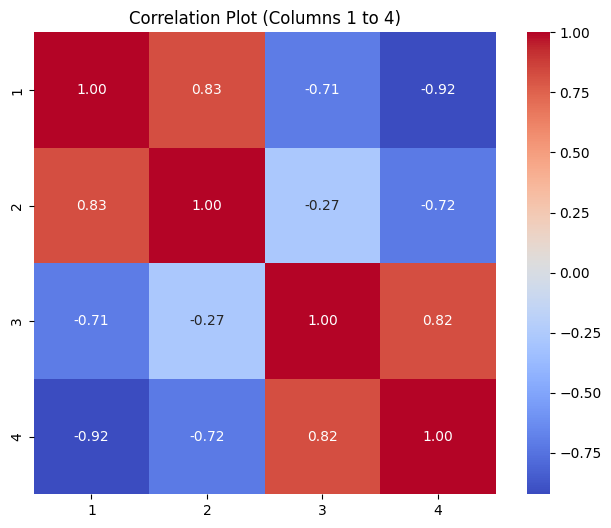

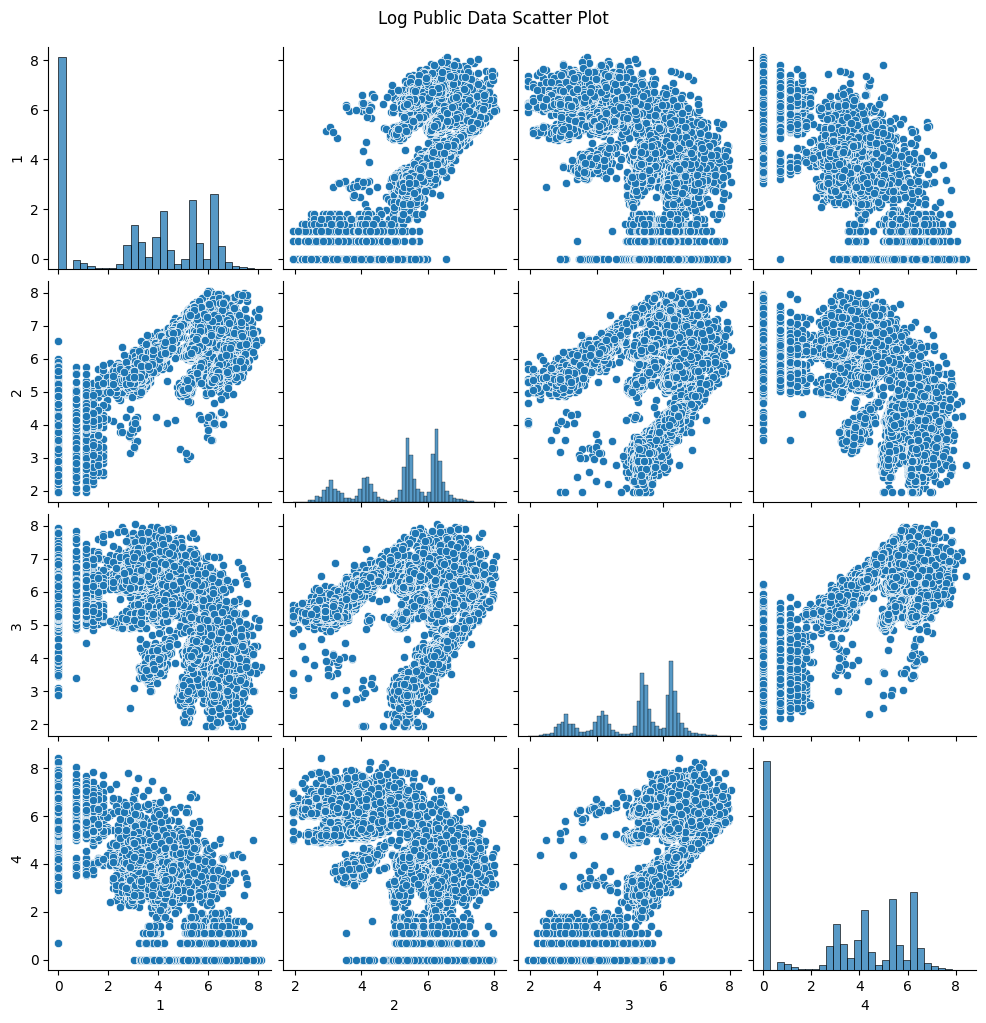

In [ ]:
# 計算欄位 1 至 4 的相關係數矩陣
correlation_matrix = log_data.corr()

# 繪製 heatmap 相關係數圖
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Plot (Columns 1 to 4)")
plt.show()

import seaborn as sns
h = sns.pairplot(log_data)
h.fig.suptitle("Log Public Data Scatter Plot", y=1.02)  # y=1.02 調整標題位置，避免與圖表重疊


# 顯示圖表
plt.show()

考慮 異常值修剪

使用 Z-score 將每欄轉換為平均值 0、標準差 1 的形式。

異常值修剪（Elliptic Envelope）：

      移除大約 1% 或 5% 的 multivariate 異常值，以提升聚類準確性。

PCA 降維：

      將標準化後資料降至 2 維，以利後續可視化與聚類。


KMeans 聚類分析：

      對修剪後資料進行分群，並記錄對應 PCA 投影與群集標籤。

接下來的步驟與結果摘要：

1. 標準化（Standardization）：將 log(1 + x) 轉換後的資料進行 zero-mean、unit-variance 標準化。

2. 執行分群：KMeans

3. 嚐試各種分群和其改善方法

4. 可視化: 採用主成分分析（PCA）：將資料用前 2 維，便於可視化與顯示聚類。

pca = PCA(n_components=4)

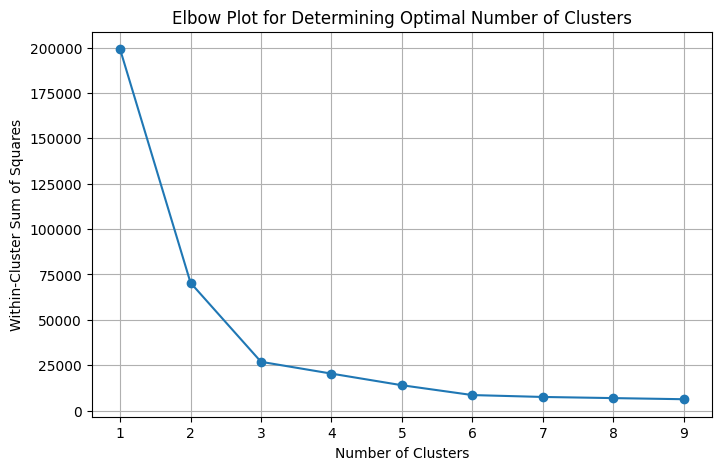

,PC1,PC2,PC3,PC4
1,-0.549,0.117,0.698,-0.445
2,-0.446,0.696,-0.116,0.551
3,0.445,0.699,-0.116,-0.547
4,0.549,0.115,0.697,0.446


In [ ]:
# 使用實際存在的欄位 1 ~ 4 執行 PCA + Elbow Plot
features = ['1', '2', '3', '4']
log_data = np.log1p(df[features])

# 標準化處理
scaler = StandardScaler()
log_scaled = scaler.fit_transform(log_data)

# PCA
pca = PCA(n_components=len(features))
pca_result = pca.fit_transform(log_scaled)

# loading matrix
loading_matrix = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(len(features))]
)

# Elbow plot: within-cluster sum of squares
sse = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(log_scaled)
    sse.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker='o')
plt.title("Elbow Plot for Determining Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# 顯示 loading matrix
loading_matrix.round(3)


**PCA 4D + log + KMeans 分群視覺化（k=15） Score**: 0.7813

各主成分解釋變異量（%）： [63.39033051 19.99992917 14.9366697   1.18120378]

總解釋變異量（%）： 99.50813316071803

Saving public_data.csv to public_data (1).csv


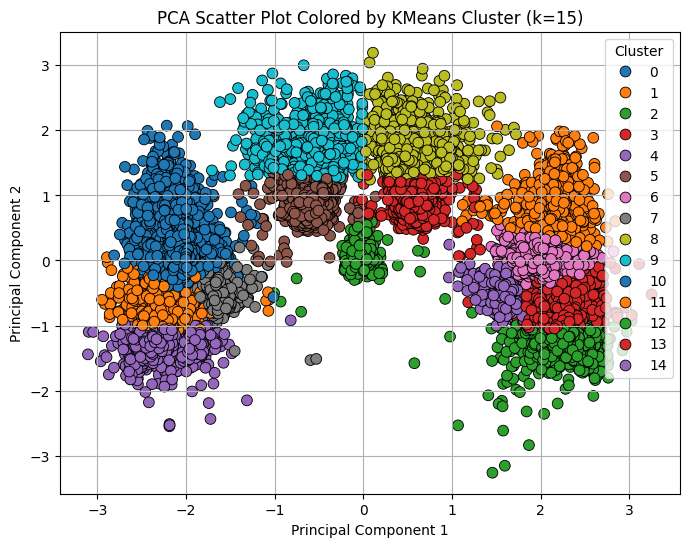

In [ ]:
# 環境重設後重新執行：PCA + log + KMeans 分群視覺化（k=15）
# Step 0: 檔案上傳
from google.colab import files
uploaded = files.upload()

# Step 1: 套件與資料
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: 讀檔與前處理
# 對欄位 1 至 4 取對數（加 1 避免 log(0)）
df = pd.read_csv("public_data.csv")  # 確認你的檔名一致
log_data = np.log1p(df[['1', '2', '3', '4']])
scaled_data = StandardScaler().fit_transform(log_data)

# PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)

# KMeans 分群，k=15（根據 Elbow Plot）
kmeans = KMeans(n_clusters=15, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# 建立結果表
pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2", "PCA3", "PCA4"])
pca_df["Cluster"] = cluster_labels
pca_df["ID"] = df["id"]

# 畫出前兩主成分的群集視覺化
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=60, edgecolor="black")
plt.title("PCA Scatter Plot Colored by KMeans Cluster (k=15)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [ ]:
# Final Step : 輸出結果到 public_submission.csv
submission = pd.DataFrame({
    "id": pca_df["ID"],
    "label": pca_df["Cluster"]
})
submission.to_csv("public_submission.csv", index=False)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score

# 1. PCA 降維（高維度，不是用來視覺化，而是去除雜訊）
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)  # fit + transform 一次完成

# 2. KMeans 分群（4N+1決定 best_k）
best_k = 15
kmeans_high = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels_high = kmeans_high.fit_predict(pca_result)

submission = pd.DataFrame({
    "id": df["id"],         # 原始 ID
    "label": kmeans_labels_high      # 高維 PCA 上的分群結果
})
submission.to_csv("public_submission_4PCA_kmeans.csv", index=False)
print(" 已儲存 public_submission_4PCA_kmeans.csv")
print("各主成分解釋變異量（%）：", pca.explained_variance_ratio_ * 100)
print("總解釋變異量（%）：", np.sum(pca.explained_variance_ratio_) * 100)

 已儲存 public_submission_4PCA_kmeans.csv
各主成分解釋變異量（%）： [63.39033051 19.99992917 14.9366697   1.18120378]
總解釋變異量（%）： 99.50813316071803


In [ ]:
best_k = (num_columns*4)-1
best_k
print(f"資料維度：{num_columns}")
print(f"分幾群：{best_k}")
data_length = df.shape[0]
print(f"資料總筆數為：{data_length}")

資料維度：4
分幾群：15
資料總筆數為：49771


## K mean + 1logp

In [ ]:
# 假設 scaled_data 與 df 已經定義並包含 ID 欄位
best_k = num_columns*4-1
kmeans = KMeans(n_clusters=15, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# 輸出分群結果
submission = pd.DataFrame({
    "id": df["id"],          # 取 df["id"]
    "label": cluster_labels   # 直接使用剛剛 fit_predict 得到的結果
})
submission.to_csv("public_submission.csv", index=False)
print("已儲存 public_submission.csv")

已儲存 public_submission.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# # Step 1: 載入資料與標準化（log + standardize）
# df = pd.read_csv("/content/public_data.csv")
# raw_data = df[['1', '2', '3', '4']]
# scaled_data = StandardScaler().fit_transform(np.log1p(raw_data))
# id_list = df["id"].values
# best_k = 15

# --- PCA 4D + KMeans ---Score: 0.7813
pca4 = PCA(n_components=4)
pca_4d = pca4.fit_transform(scaled_data)
labels_pca4d = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit_predict(pca_4d)
pd.DataFrame({"id": id_list, "label": labels_pca4d}).to_csv("public_submission_pca4d_kmeans.csv", index=False)

# --- PCA 2D + KMeans ---Score: 0.7704
pca2 = PCA(n_components=2)
pca_2d = pca2.fit_transform(scaled_data)
labels_pca2d = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit_predict(pca_2d)
pd.DataFrame({"id": id_list, "label": labels_pca2d}).to_csv("public_submission_pca2d_kmeans.csv", index=False)

print("已產出 public_submission_pca4d_kmeans.csv 與 public_submission_pca2d_kmeans.csv")


✅ 已產出 public_submission_pca4d_kmeans.csv 與 public_submission_pca2d_kmeans.csv


In [ ]:
# 一次產出多種分群模型的 public_submission_xxx.csv（含 DBSCAN、GMM、Spectral、Agglomerative）

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

id_list = df["id"].values


# -- DBSCAN Score: 0.3853
labels_dbscan = DBSCAN(eps=0.5, min_samples=10).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_dbscan}).to_csv("public_submission_dbscan.csv", index=False)

# -- GMM（Gaussian Mixture Model）Score: 0.7976
labels_gmm = GaussianMixture(n_components=best_k, covariance_type='diag', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_gmm}).to_csv("public_submission_gmm.csv", index=False)


# -- Spectral Clustering（使用預設 affinity='nearest_neighbors'）Score: 0.8261
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans', affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral.csv", index=False)



### **改善方法一 GaussianMixture 目前為最佳方案 Score: 0.8548**




In [ ]:
from sklearn.mixture import GaussianMixture
id_list = df["id"].values
best_k = (num_columns*4)-1
best_k
# --- 改善方法一：GMM with full covariance ---Score: 0.8548
gmm_full = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm_full_labels = gmm_full.fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": gmm_full_labels}).to_csv("public_submission_gmm_full.csv", index=False)

### **改善方法二 優化 Spectral Clustering**

In [ ]:
# --- 改善方法 n_neighbors=5 Score: 0.8336
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans',n_neighbors=5, affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral_5neighbors.csv", index=False)
# --- 改善方法 n_neighbors=6 Score: 0.8332
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans',n_neighbors=6, affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral_6neighbors.csv", index=False)
# --- 改善方法 n_neighbors=7 Score: 0.8370
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans',n_neighbors=7, affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral_7neighbors.csv", index=False)
# --- 改善方法 n_neighbors=8 Score: 0.8264
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans',n_neighbors=8, affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral_8neighbors.csv", index=False)
# --- 改善方法 n_neighbors=9 Score: 0.8269
labels_spectral = SpectralClustering(n_clusters=best_k, assign_labels='kmeans',n_neighbors=9, affinity='nearest_neighbors', random_state=42).fit_predict(scaled_data)
pd.DataFrame({"id": id_list, "label": labels_spectral}).to_csv("public_submission_spectral_9neighbors.csv", index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


## 可視化分群結果 GMM full 和 diag

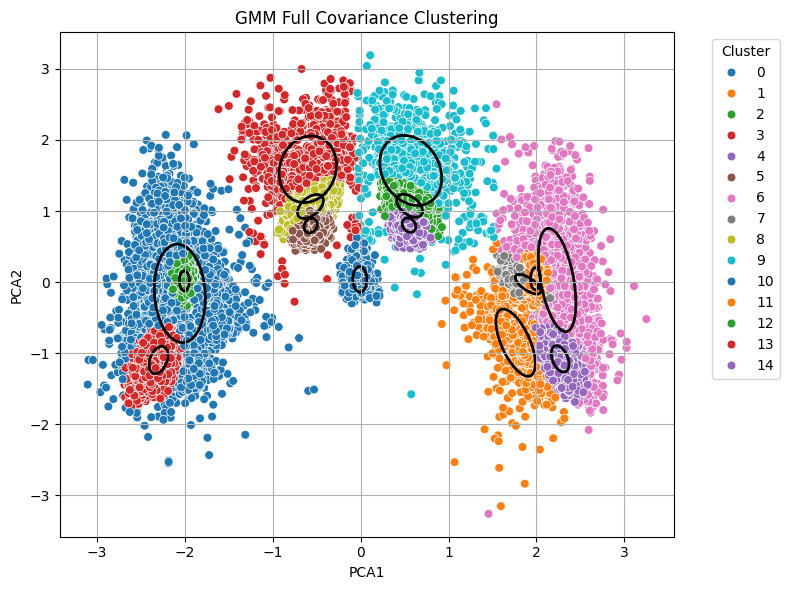

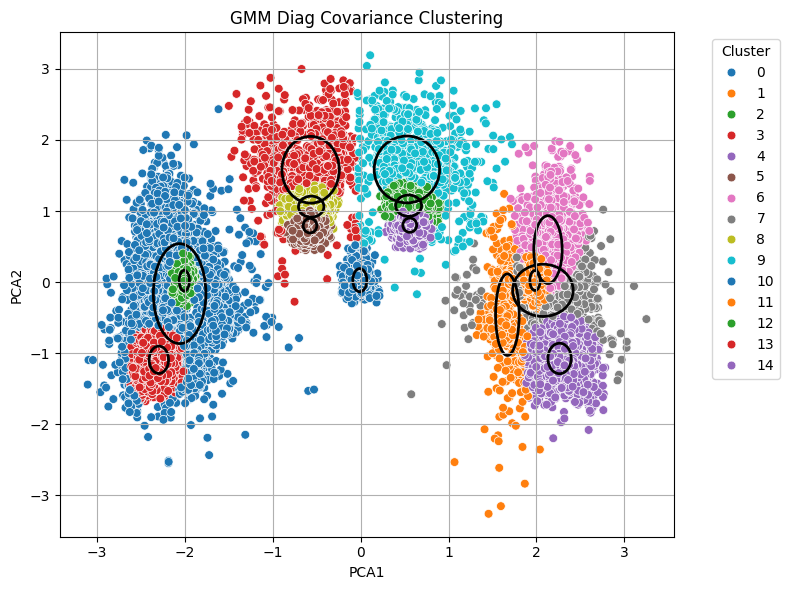

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

# PCA 降到 2 維
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# 擬合 GMM full 和 diag
n_clusters = 15
gmm_full = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42).fit(pca_data)
gmm_diag = GaussianMixture(n_components=n_clusters, covariance_type='diag', random_state=42).fit(pca_data)

labels_full = gmm_full.predict(pca_data)
labels_diag = gmm_diag.predict(pca_data)

def plot_gmm_clusters(pca_data, labels, gmm, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='tab10', s=40, legend=True)
    plt.title(title)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')


    for i in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[i]
        elif gmm.covariance_type == 'diag':
            cov = np.diag(gmm.covariances_[i])
        else:
            continue

        mean = gmm.means_[i]
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)
        ell = Ellipse(mean, width, height, angle=angle, edgecolor='black', facecolor='none', lw=2)
        plt.gca().add_patch(ell)

    plt.grid(True)
    plt.tight_layout()

# 畫圖
plot_gmm_clusters(pca_data, labels_full, gmm_full, "GMM Full Covariance Clustering")
plot_gmm_clusters(pca_data, labels_diag, gmm_diag, "GMM Diag Covariance Clustering")


# --- 改善方法三：嘗試 QuantileTransformer 或 Box-Cox 轉換 + GMM 分群


重跑 GMM 分群（可與原始做比較）

In [ ]:
# 使用 QuantileTransformer 處理後的資料做 GMM 分群 Score: 0.7863

from sklearn.preprocessing import QuantileTransformer
from sklearn.mixture import GaussianMixture

# 特徵轉換
qt = QuantileTransformer(output_distribution='normal', random_state=42)
qt_data = qt.fit_transform(df[['1', '2', '3', '4']])
qt_df = pd.DataFrame(qt_data, columns=['1', '2', '3', '4'])
id_list = df['id'].values

# 分群
gmm_qt = GaussianMixture(n_components=15, covariance_type='full', random_state=42)
labels_qt = gmm_qt.fit_predict(qt_data)

# 儲存
filename = "public_submission_gmm_quantile.csv"
pd.DataFrame({"id": id_list, "label": labels_qt}).to_csv(filename, index=False)

filename


'public_submission_gmm_quantile.csv'

In [ ]:
# 使用 Box-Cox 轉換 + GMM 分群 Score: 0.7899

import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture

# 載入資料
positive_data = df[['1', '2', '3', '4']] + 1e-3
id_list = df['id'].values

# Box-Cox 轉換
boxcox = PowerTransformer(method='box-cox', standardize=True)
boxcox_data = boxcox.fit_transform(positive_data)
boxcox_df = pd.DataFrame(boxcox_data, columns=['1', '2', '3', '4'])
# GMM 分群
gmm_boxcox = GaussianMixture(n_components=15, covariance_type='full', random_state=42)
labels_boxcox = gmm_boxcox.fit_predict(boxcox_data)

# 輸出結果
filename = "public_submission_gmm_boxcox.csv"
pd.DataFrame({"id": id_list, "label": labels_boxcox}).to_csv(filename, index=False)

filename

'public_submission_gmm_boxcox.csv'

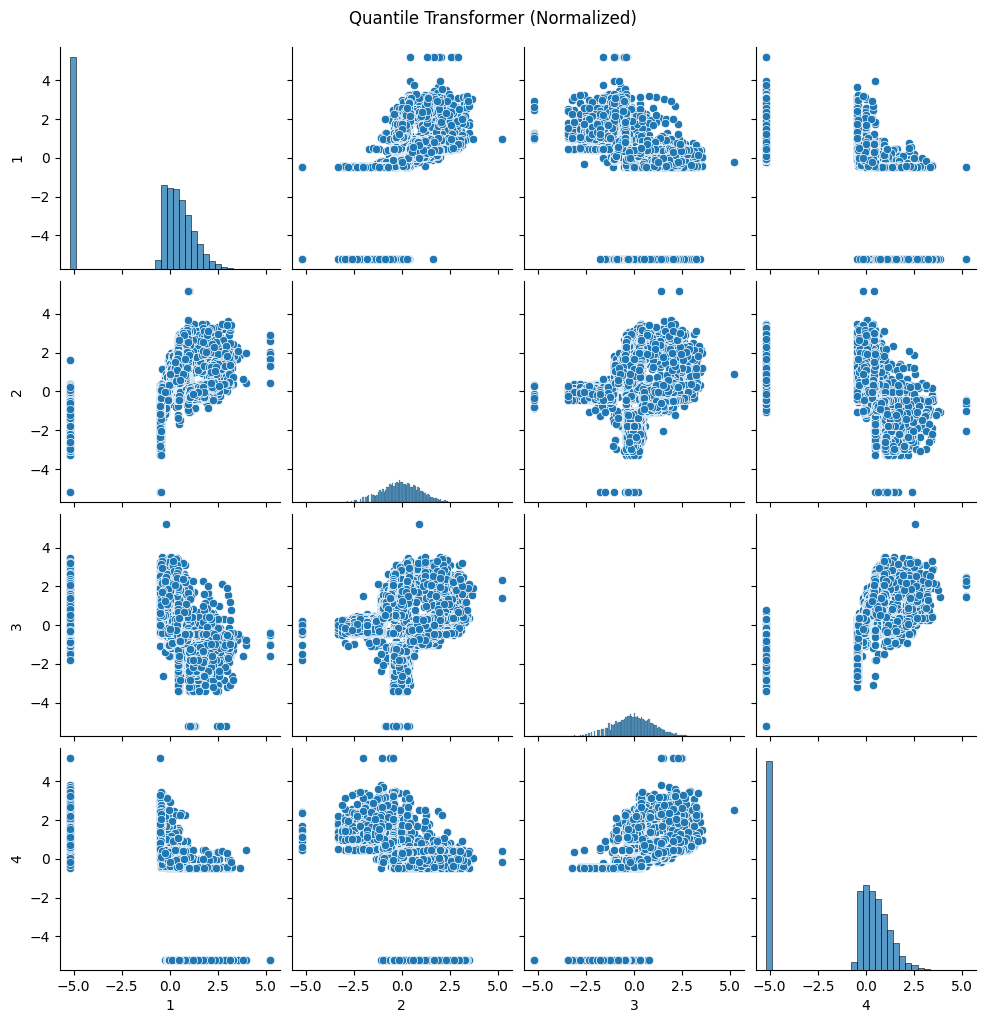

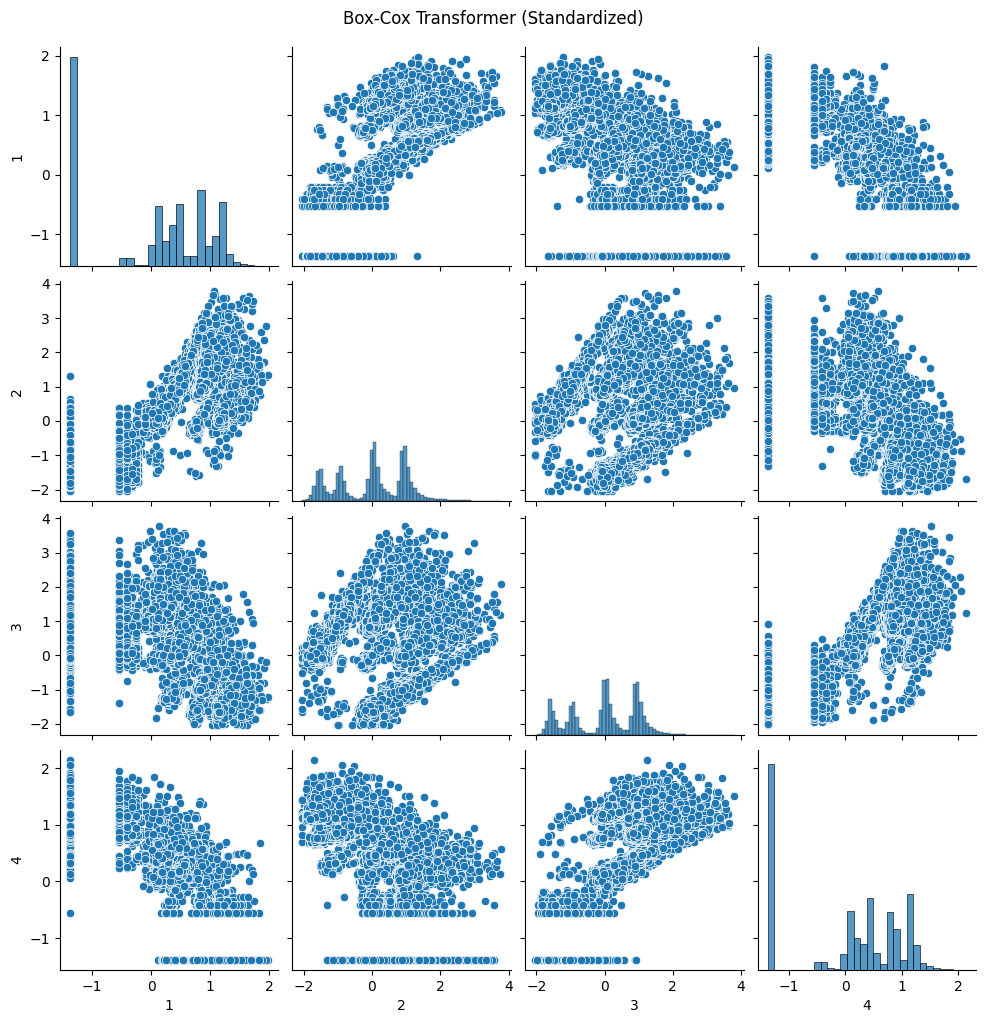

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 第一張圖：QuantileTransformer 的結果
sns.pairplot(qt_df)
plt.suptitle("Quantile Transformer (Normalized)", y=1.02)
plt.show()

# 第二張圖：Box-Cox 的結果
sns.pairplot(boxcox_df)
plt.suptitle("Box-Cox Transformer (Standardized)", y=1.02)
plt.show()

## --- 改善方法四：執行「離群值處理」：訓練於非離群資料，預測所有 id 的 label
public_submission_gmm_fullpredict_contam_01.csv' Score: 0.7882

public_submission_gmm_fullpredict_contam_05.csv' Score: 0.8055

In [ ]:
# --- 改善方法二：執行「離群值處理」：訓練於非離群資料，預測所有 id 的 label

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope


contamination_values = [0.01, 0.03, 0.05]
full_id_predictions = []

for contamination in contamination_values:
    try:
        env = EllipticEnvelope(contamination=contamination, random_state=42)
        mask = env.fit_predict(scaled_data) == 1
        filtered_data = scaled_data[mask]

        gmm = GaussianMixture(n_components=15, covariance_type='full', random_state=42)
        gmm.fit(filtered_data)

        full_pred_labels = gmm.predict(scaled_data)

        filename = f"public_submission_gmm_fullpredict_contam_{int(contamination*100):02d}.csv"
        pd.DataFrame({"id": id_list, "label": full_pred_labels}).to_csv(filename, index=False)
        full_id_predictions.append(filename)
    except Exception as e:
        print(f"Contamination {contamination} 發生錯誤：{e}")

full_id_predictions


['public_submission_gmm_fullpredict_contam_01.csv',
 'public_submission_gmm_fullpredict_contam_03.csv',
 'public_submission_gmm_fullpredict_contam_05.csv']

## Agglomerative Clustering  採用 KNN graph 作為 connectivity
(避免計算完整距離矩陣來增加計算複雜度)
原本需要更多的記憶體資源 Your session crashed after using all available RAM

改採用 KNN graph 作為 connectivity（避免計算完整距離矩陣）來建立 AgglomerativeClustering 模型（使用 KNN graph）FMI = 0.8391

In [ ]:
# -- Agglomerative Clustering
# from sklearn.cluster import  AgglomerativeClustering
# labels_agglomerative = AgglomerativeClustering(n_clusters=best_k).fit_predict(scaled_data)
# pd.DataFrame({"id": id_list, "label": labels_agglomerative}).to_csv("public_submission_agglomerative.csv", index=False)

# print(" public_submission_xxx.csv 檔案已成功產出Agglomerative")
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# 建立 KNN graph 作為 connectivity（避免計算完整距離矩陣）
connectivity = kneighbors_graph(scaled_data, n_neighbors=10, include_self=False)

# 建立 AgglomerativeClustering 模型（使用 KNN graph）
agglo = AgglomerativeClustering(n_clusters=best_k, connectivity=connectivity)
labels_agglomerative = agglo.fit_predict(scaled_data)

# 匯出結果
pd.DataFrame({
    "id": df["id"],
    "label": labels_agglomerative
}).to_csv("public_submission_agglomerative_knn.csv", index=False)

print(" Agglomerative clustering with KNN graph finished and exported.")


 Agglomerative clustering with KNN graph finished and exported.


## HDBSCAN 分群 + KNN1補標籤 Score: 0.7621

In [ ]:
# # 安裝 HDBSCAN
# !pip install hdbscan
# from sklearn.neighbors import KNeighborsClassifier
# import hdbscan
# import pandas as pd
# import numpy as np

# Step 1: 前處理
# Step 2: 執行 HDBSCAN 分群
hdb = hdbscan.HDBSCAN(
    min_cluster_size=15,       # 視資料調整
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom'
)
labels_hdb = hdb.fit_predict(scaled_data)

# Step 3: 建 DataFrame 與找出離群點
df_result = pd.DataFrame({"id":  df["id"], "label": labels_hdb})
df_features = pd.DataFrame(scaled_data)

X_labeled = df_features[df_result['label'] != -1]
y_labeled = df_result['label'][df_result['label'] != -1]
X_outliers = df_features[df_result['label'] == -1]
id_outliers = df_result['id'][df_result['label'] == -1]

# Step 4: 使用 KNN 補標籤
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_labeled, y_labeled)
y_outliers = knn.predict(X_outliers)

# Step 5: 替代 -1 標籤
df_result.loc[df_result['label'] == -1, 'label'] = y_outliers

# Step 6: 匯出結果
df_result.to_csv("public_submission_hdbscan_filled.csv", index=False)
print("已完成：HDBSCAN 分群 + 離群點補標籤 ➜ public_submission_hdbscan_filled.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


已完成：HDBSCAN 分群 + 離群點補標籤 ➜ public_submission_hdbscan_filled.csv
